# LLM - Bielik - Fine tuning - part II

In [1]:
# ! pip install bitsandbytes
# ! pip install transformers
# ! pip install accelerate
# ! pip install peft
# ! pip install wandb
# ! pip install datasets
# ! pip install ipywidgets==8.1.3
# ! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [2]:
import matplotlib.pyplot as plt

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "speakleash/Bielik-11B-v2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
def format_for_output(data):
    text = f"### Question: {data['question']}\n ### Answer: {data['answer']}"
    return text

In [7]:
def generate_and_tokenize_prompt(prompt):
    return tokenizer(format_for_output(prompt))

In [8]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='ft_output_data/data_ft_20240818_133719_train.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='ft_output_data/data_ft_20240818_133719_eval.jsonl', split='train')

In [9]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/799 [00:00<?, ? examples/s]

Map:   0%|          | 0/225 [00:00<?, ? examples/s]

In [10]:
tokenized_train_dataset

Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask'],
    num_rows: 799
})

1024


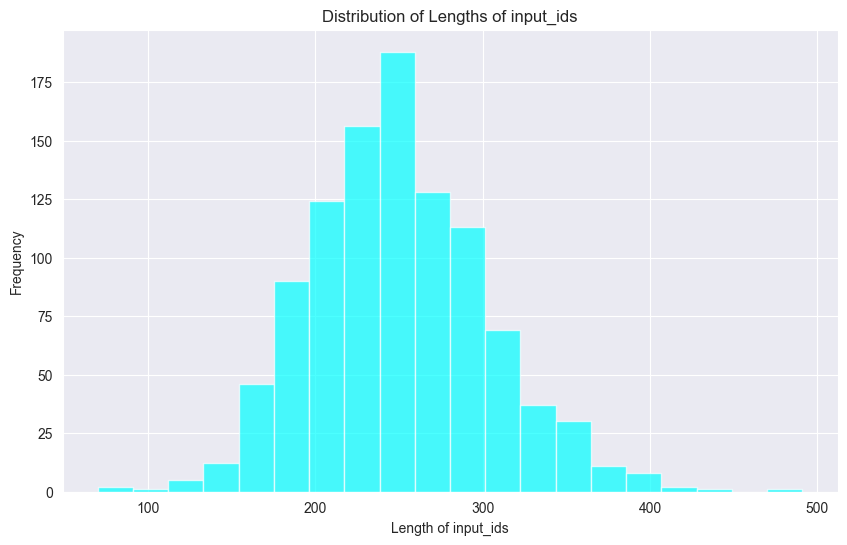

In [13]:
def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='cyan')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [14]:
max_length = 512 # This was an appropriate max length for my dataset

def generate_and_tokenize_with_truncation(prompt):
    result = tokenizer(
        format_for_output(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [15]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_with_truncation)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_with_truncation)

Map:   0%|          | 0/799 [00:00<?, ? examples/s]

Map:   0%|          | 0/225 [00:00<?, ? examples/s]

1024


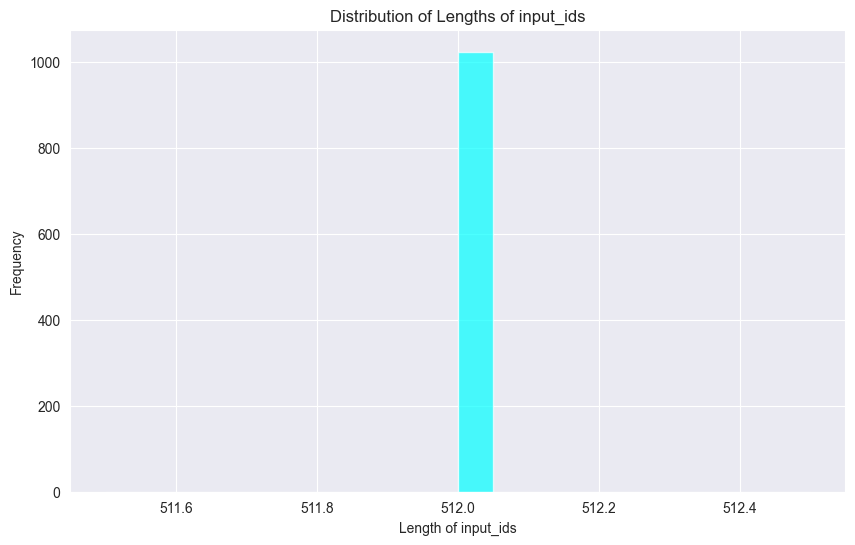

In [16]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [17]:
evaluation_prompt = 'Jakie są zagrożenia zwiazane z umową?'

In [18]:
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(evaluation_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\transformers\models\mistral\modeling_mistral.py:647: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Jakie są zagrożenia zwiazane z umową?
- wysokie koszty początkowe (prowizja, ubezpieczenie) - mogą obniżyć rentowność inwestycji;
- ryzyko przedterminowego rozwiązania umowy - może spowodować utratę części lub całości środków zainwestowanych w produkt;
- ryzyko związane ze zmianami prawa podatkowego. W przypadku wygaśnięcia umowy na skutek zaprzestania opłacania składek lub rezygnacji z ochrony ubezpieczeniowej, Ubezpieczyciel wypłaci Ubezpieczającemu kwotę równą wartości jednostek uczestnictwa według stanu na dzień wygaśnięcia Umowy i Ceny Jednostki Uczestnictwa Funduszu z najbliższego Dnia Wyceny następującego niezwłocznie po otrzymaniu przez Ubezpieczyciela dokumentów


In [19]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [20]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [21]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 132231168 || all params: 5848432640 || trainable%: 2.2609676154190947


In [22]:
from accelerate import Accelerator
accelerator = Accelerator()
model = accelerator.prepare_model(model)

In [23]:
import transformers
from datetime import datetime

project = "legal-finetune"
base_model_name = "bielik_v2"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=2,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs
wandb: Currently logged in as: zvit3k (zvit3k-kodio). Use `wandb login --relogin` to force relogin


C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss
25,0.629200,0.502557
50,0.462400,0.480181
75,0.483000,0.472273
100,0.464600,0.467663
125,0.460200,0.463724
150,0.451200,0.458845
175,0.456600,0.456906
200,0.467500,0.454600
225,0.423900,0.453111
250,0.432100,0.449372


C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\peft\utils\save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torc

TrainOutput(global_step=500, training_loss=0.4287638568878174, metrics={'train_runtime': 1987.8535, 'train_samples_per_second': 0.503, 'train_steps_per_second': 0.252, 'total_flos': 3.4278181234016256e+16, 'train_loss': 0.4287638568878174, 'epoch': 1.25})

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "speakleash/Bielik-11B-v2"
bnb_config = BitsAndBytesConfig(
    # llm_int8_enable_fp32_cpu_offload=True,
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True
)
# 


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "bielik_v2-legal-finetune/checkpoint-500")

In [ ]:
# eval_tokenizer.apply_chat_template(return_tensors="pt")

In [9]:
evaluation_prompt = "W jaki sposób przedsiębiorca może udowodnić, że nie znał danego publicznego zapewnienia i rozsądnie nie mógł o nim wiedzieć?"
model_input = eval_tokenizer(evaluation_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=600, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\transformers\models\mistral\modeling_mistral.py:647: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


W jaki sposób przedsiębiorca może udowodnić, że nie znał danego publicznego zapewnienia i rozsądnie nie mógł o nim wiedzieć? Czy istotne jest to, czy dane zapewnienie zostało opublikowane na stronie internetowej przedsiębiorcy? Powrót do artykułu: Jak udowodnić brak znajomości treści publicznych zapewnień
